A notebook to experiment with decoding a generated image from a GAN model. Decoding here refers to the task of finding the noise vector $z$ for a GAN model $g$ such that $g(z)$ (generated image) is closest to a given image.

LSUN data. Use models from https://arxiv.org/abs/1801.04406

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'pdf'

In [2]:
import kbrgan
import kbrgan.kernel as kernel
import kbrgan.glo as glo
import kbrgan.gen as gen
import kbrgan.main as main
import kbrgan.plot as plot
import kbrgan.net.net as net
import kbrgan.util as util

import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
import scipy.stats as stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [3]:
# font options
font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 18
}

plt.rc('font', **font)
plt.rc('lines', linewidth=2)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
# True to use GPU
use_cuda = True and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
tensor_type = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
torch.set_default_tensor_type(tensor_type)

# load option depends on whether GPU is used
load_options = {'map_location': lambda storage, loc: storage.cuda(0)} if use_cuda \
    else {'map_location': lambda storage, loc: storage} 


In [5]:
t =torch.rand(2, 3)
torch.std?

## Load an LSUN model from https://arxiv.org/abs/1801.04406

In [88]:
import ganstab
import ganstab.configs
from ganstab.gan_training.config import (load_config, build_generator, build_models)
from ganstab.gan_training.distributions import get_ydist, get_zdist
from ganstab.gan_training.checkpoints import CheckpointIO
# ('cub.yaml', 'CUB_data/model.pt', 
# # generator's type
g_type = 'cub.yaml'
# # relative generator path
# # g_rel_path = 'gan_data/lsun_bridge/chkpts/model.pt'
checkpoint_dir = glo.share_path('CUB_data')

# # generator's type
# g_type = 'lsun_church.yaml'
# # relative generator path
# # g_rel_path = 'gan_data/lsun_bridge/chkpts/model.pt'
# checkpoint_dir = glo.share_path('gan_data', 'lsun_church', 'chkpts')

# generator's type
#g_type = 'lsun_tower.yaml'
# relative generator path
# g_rel_path = 'gan_data/lsun_bridge/chkpts/model.pt'
#checkpoint_dir = glo.share_path('gan_data', 'lsun_tower', 'chkpts')


In [89]:
# Loading Configs for LarsGAN
yaml_folder = os.path.dirname(ganstab.configs.__file__)
yaml_config_path = os.path.join(yaml_folder, g_type)
config = load_config(yaml_config_path)

In [90]:
generator = build_generator(config)
# Put models on gpu if needed
with torch.enable_grad(): #use_cuda??????
    generator = generator.to(device)
    
# Use multiple GPUs if possible
generator = nn.DataParallel(generator)

checkpoint_io = CheckpointIO(checkpoint_dir=checkpoint_dir)    
# Register modules to checkpoint
checkpoint_io.register_modules(generator=generator)

# Test generator
if config['test']['use_model_average']:
    import copy
    generator_test = copy.deepcopy(generator)
    checkpoint_io.register_modules(generator_test=generator_test)
else:
    generator_test = generator

# Loading Generator
# it = checkpoint_io.load(glo.share_path(g_rel_path))
it = checkpoint_io.load('model.pt')

=> Loading checkpoint from /notebooks/psangkloy3/gdrive/condgan_share/CUB_data/model.pt


In [91]:
# load option depends on whether GPU is used
device_load_options = {} if use_cuda else {'map_location': lambda storage, loc: storage}
 
# Put models on gpu if needed
with torch.enable_grad():
    generator_test = generator_test.to(device)

In [92]:
class LarsGenerator(gen.PTNoiseTransformerAdapter):
    def __init__(self, ydist, module, tensor_type=torch.cuda.FloatTensor):
        f_sample_noise = lambda n: torch.randn(n, 256).float()
        in_out_shapes = (256, (3, 256, 256))
        super(LarsGenerator, self).__init__(module, f_sample_noise, in_out_shapes, tensor_type)
        self.post_process = gen.LinearRangeTransform(from_range=(-1,1), to_range=(0,1))
        self.ydist = ydist
        
        
    def forward(self, Z):
        # self.generator is the same as self.module
        y_sam = self.ydist.sample((Z.shape[0], ))
        sam_minus1_plus1 = self.module.forward(Z, y_sam)
        # make sure to transform the output to (0,1)
#         print(dir(self))
        result = self.post_process.forward(sam_minus1_plus1)
#         result = sam_minus1_plus1
        return result
    
# Construct a generator
nlabels = config['data']['nlabels']  
ydist = get_ydist(nlabels, device=device)
g = LarsGenerator(ydist, generator_test)

In [93]:
def save_image(x, path='real_image.png',size=256):
    transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size=size),
    transforms.ToTensor()
])
    x = transform(x.detach().cpu())

    torchvision.utils.save_image(x, path)
    

In [32]:
from tqdm import tqdm, tqdm_notebook
import os, sys

In [ ]:
with tqdm_notebook(total=len(data), file=sys.stdout) as pbar:
    for i,item in enumerate(data):
        #sys.stdout.flush()
        pbar.set_description('processed: %d' % (1 + i))
        pbar.update(1)
        if (not os.path.exists('../../../gdrive/condgan_share/validation_imgs/celeba/'+item)) and (os.path.exists(os.path.join('../../../img_align_celeba/',item))):
            copyfile(os.path.join('../../../img_align_celeba/',item),'../../../gdrive/condgan_share/validation_imgs/celeba/'+item)
    

In [94]:
!mkdir /notebooks/psangkloy3/gdrive/condgan_share/prior_samples/CUB_lars/

In [80]:
!rm -rf /notebooks/psangkloy3/gdrive/condgan_share/prior_samples/celeba_hq_/

In [95]:
num_sample = 1000
with tqdm_notebook(total=num_sample, file=sys.stdout) as pbar:
    for i in range(num_sample):
        n_sample = 1
        pbar.set_description('processed: %d' % (1 + i))
        z = torch.randn(n_sample, 256).float()
        g_samples = g.forward(z)
        save_image(g_samples[0],glo.share_path('prior_samples','CUB_lars',"%04d.jpg" % (i,)))
        pbar.update(1)

/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


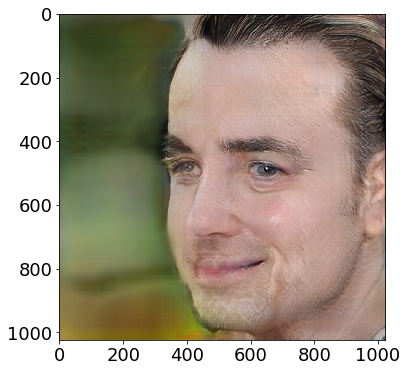

In [57]:
n_sample = 1
z = torch.randn(n_sample, 256).float()
g_samples = g.forward(z)
plot.show_torch_imgs(g_samples.detach().cpu(), nrow=4, normalize=True, figsize=(10, 6))

In [ ]:
for 

In [ ]:
stats.describe(g_samples.detach().cpu().numpy().reshape(-1))

In [ ]:
print('Generator output shape:', g_samples[0].shape)

## $\arg\min_z \|g(z) - y\|_p^2$ where $y$ is an image of a digit.

Load an image

In [ ]:
import imageio
# img_fname = '0a179ae9d4cc0144343aedd4a87aa686419dfd19.png'
# img_fname = '014fa62f91297b31ba43d0e7b14d8df256da287d.png'
img_fname = '05c622a21e04560050cce84192a79765973a60b3.png'
img_path = glo.share_path('lsun_imgs', 'bedroom', img_fname)
img = imageio.imread(img_path)
print(stats.describe(img.reshape(-1)))

In [ ]:
plt.imshow(img);
print('Image shape:', img.shape)

Convert to float in range [0,1], and resize to 256 x 256

In [ ]:
import skimage
import kbrgan.imutil as imutil
float_img = imutil.numpy_image_to_float(img)
# plt.imshow(float_img);

# resize
resized = skimage.transform.resize(float_img, (256, 256))
plt.imshow(resized)
print(stats.describe(resized.reshape(-1)))

Construct a Pytorch image

In [ ]:
# Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a 
# torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
torch_converter = transforms.ToTensor()
pt_img = torch_converter(resized).to(device).type(tensor_type)
plot.show_torch_imgs(pt_img)
print('Pytorch image shape:', pt_img.shape)

Optimization to find an approximate inverse of the generator

In [ ]:
squared_loss = lambda x, y: torch.sum( (x-y)**2 )
l1_loss = lambda x,y: torch.sum( torch.abs(x-y) )
# f_loss = squared_loss
f_loss = l1_loss
opts = {
    'n_opt_iter': 100,
    'lr': 1e-2,
}
input_img = pt_img.to(device)

# initialize z
z0 = g.sample_noise(1)
z0 = z0.to(device)
z0.requires_grad = True

with torch.no_grad():
    y0 = g(z0)
#     plot.show_torch_imgs(y0)

losses, Zs = gen.decode_generator(g, z0, input_img, f_loss, **opts)

Plot the recorded losses

In [ ]:
n_opt_iter = opts['n_opt_iter']
plt.plot(losses, 'b-', label='Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss');

Plot the recorded noise vectors during the optimization (as images)

In [ ]:
n_every = 10
Zs_toshow = Zs[0::n_every]
n_toshow = len(Zs_toshow)

# transform to get images
with torch.no_grad():
    Z_cat = torch.cat(Zs_toshow, dim=0).to(device)
    gen_toshow = g.forward(Z_cat)
    

In [ ]:
print('Optimized images. Every {} iterations.'.format(n_every))
plot.show_torch_imgs(gen_toshow, nrow=4, figsize=(10, 6))

In [ ]:
print('Conditioned image')
plot.show_torch_imgs(input_img)